In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

from imblearn.metrics import sensitivity_score, specificity_score

from sklearn.metrics import roc_curve, auc
from scipy import stats

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

pd.set_option('display.max_columns', None)

2024-06-12 21:32:27.473218: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-12 21:32:27.677371: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-12 21:32:28.578556: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 21:32:31.012282: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
class ValueReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, replace_dict):
        self.replace_dict = replace_dict

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        return X.replace(self.replace_dict)

    def get_feature_names_out(self, names):
        return names

    def set_output(self, *, transform):
        assert transform == 'pandas'


In [3]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        
        if X.columns is not None:
            X = X.drop(self.columns, axis=1)
            self.feature_names = [name for name in X.columns if name not in self.columns]
            
        return X

    def get_feature_names_out(self, names):
        if names is None:
            return names
            
        return [name for name in names if name not in self.columns]


    def set_output(self, *, transform):
        assert transform == 'pandas'


In [4]:
class ZScoreOutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, cols, factor=3):
        self.factor = factor
        self.cols = cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        print('LEN' + str(len(X[(np.abs(stats.zscore(X[self.cols], nan_policy='omit', axis=0)) > self.factor).any(axis=1)])))
        return X[~(np.abs(stats.zscore(X[self.cols], nan_policy='omit', axis=0)) > self.factor).any(axis=1)]

    def get_feature_names_out(self, names):
        return names
        
    def set_output(self, *, transform):
        assert transform == 'pandas'

    

In [5]:
class RangeOutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, col, min, max):
        self.col = col
        self.min = min
        self.max = max
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[(X[self.col] >= self.min) & (X[self.col] <= self.max) | X[self.col].isna()]

    def get_feature_names_out(self, names):
        return names
        
    def set_output(self, *, transform):
        assert transform == 'pandas'

    

In [6]:
class ColumnBackPusher(BaseEstimator, TransformerMixin):
    def __init__(self, col):
        self.col = col

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        col = X[self.col]
        X = X.drop(self.col, axis=1)
        return pd.concat([X, col], axis=1)
        
    def get_feature_names_out(self, names):
        return [name for name in names if name != self.col] + [self.col]
        
    def set_output(self, *, transform):
        assert transform == 'pandas'


In [7]:


class IndicatorLabelProducer():
    def __init__(self, indicator_map):
        self.indicator_map = indicator_map

    def __call__(self, given_label: str) -> str:
        if '|' in given_label:
            given_label = given_label.split('|')[1]

        
        diagset = set(given_label)
        
        for label, options in self.indicator_map.items():
            if not diagset.isdisjoint(set(options)):
                return label

        return np.NaN

class MappingLabelProducer():
    def __init__(self, mappings):
        self.mappings = mappings

    def __call__(self, given_label: str) -> str:
        if given_label in self.mappings:
            return self.mappings[given_label]

        return np.NaN
        

In [8]:
def get_dataset(fname, names_file):
    with open(names_file, 'r') as fcolnames:
        colnames = [name.split(':')[0] for name in fcolnames.readlines()]
    
        df = pd.read_csv(fname, names=colnames, index_col=False)
        return df

In [9]:
def reencode_dataset(df, label_producer):
    df['diagnosis'] = df['diagnosis'].apply(lambda ref: ref.split('[')[0])
    df['diagnosis'] = df['diagnosis'].apply(lambda ref: ref.split('.')[0])
    df['diagnosis'] = df['diagnosis'].apply(label_producer)

    for col in df.columns:
        try:
            df[col] = pd.to_numeric(df[col], errors='raise')
        except:
            pass

    return df.applymap(lambda val: np.nan if val == '?' else val)

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate(model, y, y_pred):
    # Accuracy
    print('Accuracy:', accuracy_score(y, y_pred))
    
    print('Precision (macro):', precision_score(y, y_pred, average='macro'))
    print('Precision (micro):', precision_score(y, y_pred, average='micro'))
    print('Precision (weighted):', precision_score(y, y_pred, average='weighted'))
    
    # Recall
    print('Recall (macro):', recall_score(y, y_pred, average='macro'))
    print('Recall (micro):', recall_score(y, y_pred, average='micro'))
    print('Recall (weighted):', recall_score(y, y_pred, average='weighted'))
    
    # F1-score
    print('F1-score (macro):', f1_score(y, y_pred, average='macro'))
    print('F1-score (micro):', f1_score(y, y_pred, average='micro'))
    print('F1-score (weighted):', f1_score(y, y_pred, average='weighted'))

In [11]:
classes = ['hypo', 'neg', 'hyper']

dftrain = get_dataset('ann-train.data', 'ann.names')
dftest = get_dataset('ann-test.data', 'ann.names')

dftrain = dftrain.dropna(subset=['diagnosis'])
dftest = dftest.dropna(subset=['diagnosis'])

In [12]:
dftrain

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,diagnosis
0,0.73,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0.00060,0.0150,0.120,0.082,0.146,3
1,0.24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00025,0.0300,0.143,0.133,0.108,3
2,0.47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00190,0.0240,0.102,0.131,0.078,3
3,0.64,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00090,0.0170,0.077,0.090,0.085,3
4,0.23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00025,0.0260,0.139,0.090,0.153,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,0.77,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00006,0.0206,0.125,0.107,0.117,3
3768,0.41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00130,0.0250,0.125,0.114,0.109,3
3769,0.88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01300,0.0174,0.123,0.099,0.124,2
3770,0.64,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00078,0.0206,0.106,0.088,0.121,3


In [13]:
dftest

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,diagnosis
0,0.29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00610,0.0280,0.111,0.131,0.0850,2
1,0.32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00130,0.0190,0.084,0.078,0.1070,3
2,0.35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.0310,0.239,0.100,0.2390,3
3,0.21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00100,0.0180,0.087,0.088,0.0990,3
4,0.22,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.00040,0.0220,0.134,0.135,0.0990,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3423,0.59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.00250,0.0208,0.079,0.099,0.0800,3
3424,0.51,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.10600,0.0060,0.005,0.089,0.0055,1
3425,0.51,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.00076,0.0201,0.090,0.067,0.1340,3
3426,0.35,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00280,0.0201,0.090,0.089,0.1010,3


In [14]:
indi_map = {
    'hyper' : 'ABCD',
    'hypo' : 'EFGH',
    'neg' : '-',
}

classes_map = {
    'hyperthyroid' : 'hyper',
}

df1 = get_dataset('thyroid0387.data', 'names')
df1 = reencode_dataset(df1, IndicatorLabelProducer(indi_map))

df2 = get_dataset('allhyper.data', 'names')
df2 = reencode_dataset(df2, MappingLabelProducer(classes_map))
df = pd.concat([df1, df2], ignore_index=True, axis=0)
df = df.dropna(subset=['diagnosis'])

df = df.drop_duplicates(keep='first')
df.diagnosis.value_counts()


bool_cols = ['on thyroxine', 'query on thyroxine',
       'on antithyroid medication', 'sick', 'pregnant', 'thyroid surgery',
       'I131 treatment', 'query hypothyroid', 'query hyperthyroid', 'lithium',
       'goitre', 'tumor', 'psych']

numeric_cols = ['age','TSH',
       'T3', 'TT4', 'T4U', 'FTI']

cols_to_drop = ['TSH measured',
       'T3 measured', 'TT4 measured', 'T4U measured', 
       'FTI measured', 'TBG measured', 'referral source', 'TBG', 'hypopituitary']

classes = ['hypo', 'neg', 'hyper']

def convert_to_numeric(df):
    return df.apply(pd.to_numeric, errors='coerce')

numeric_transformer = FunctionTransformer(convert_to_numeric)
label_enc = OrdinalEncoder(categories=[classes], dtype=np.int64)

prep = Pipeline(steps=[
    ('column dropper', ColumnDropper(cols_to_drop)),
    ('feature encoder', ColumnTransformer(transformers=[
        ('gender map', ValueReplacer({'M':0, 'F':1}), ['sex']),
        ('bool map', ValueReplacer({'f': 0, 't': 1}), bool_cols),
        ('label encoder',  label_enc, ['diagnosis'])
    ], remainder='passthrough', verbose_feature_names_out=False).set_output(transform="pandas")),
    ('numeric cast', numeric_transformer),
    ('zoutliers', ZScoreOutlierRemover(numeric_cols, 8)),
    ('age outliers', RangeOutlierRemover('age', 0, 100)),
    ('TSH outliers', RangeOutlierRemover('TSH', 0, 15)),
    ('label', ColumnBackPusher('diagnosis'))
]).set_output(transform='pandas')

In [15]:
df = prep.fit_transform(df)

df

LEN42


,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,lithium,goitre,tumor,psych,age,TSH,T3,TT4,T4U,FTI,diagnosis
0,1.0,0,0,0,0,0,0,0,1,0,0,0,0,0,29,0.300,NaN,NaN,NaN,NaN,1
1,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,1.600,1.9,128.0,NaN,NaN,1
2,1.0,0,0,0,0,0,0,0,0,1,0,0,0,0,41,NaN,NaN,NaN,NaN,NaN,1
3,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,NaN,NaN,NaN,NaN,NaN,1
5,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,60,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11878,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,37,NaN,4.3,187.0,0.96,194.0,2
11938,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0.015,4.8,22.0,NaN,NaN,2
11941,1.0,0,0,0,0,0,0,0,0,1,0,0,0,0,41,0.200,3.8,253.0,1.24,204.0,2
11942,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,NaN,NaN,196.0,0.94,209.0,2


In [16]:
import matplotlib.pyplot as plt

def show_history(history):
    
    plt.figure(figsize=(8, 6))
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    
    plt.title('Model metrics')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left')
    
    plt.legend(['Train loss', 'Validation loss', 'Train accuracy', 'Validation accuracy'], loc='center right')
    
    plt.show()
    

In [17]:
def get_nn_model(input_dim):
    return Sequential([
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),  
    Dense(3, activation='softmax'),
])

In [18]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
print(y.value_counts())

1    6748
0     350
2     271
Name: diagnosis, dtype: int64


In [19]:


preproc = Pipeline(steps=[
    ('scaler', ColumnTransformer(transformers=[
        ('scaler', StandardScaler(), numeric_cols),
        ], remainder='passthrough', verbose_feature_names_out=False).set_output(transform="pandas")),
    ('imputer', IterativeImputer(KNeighborsRegressor(n_neighbors=5), initial_strategy='median', add_indicator=True, max_iter=100))
]).set_output(transform='pandas')



In [20]:
X = preproc.fit_transform(X)
X

/usr/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,age,TSH,T3,TT4,T4U,FTI,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,lithium,goitre,tumor,psych,missingindicator_TSH,missingindicator_T3,missingindicator_TT4,missingindicator_T4U,missingindicator_FTI,missingindicator_sex
0,-1.231140,-0.720514,-0.036091,-0.197404,0.434449,-0.367341,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
1,-1.231140,-0.154795,-0.198871,0.655175,0.944995,-0.090085,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,-0.587557,-0.310585,0.018169,-0.037545,-0.026287,-0.077189,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
3,-0.855716,-0.119981,-0.090351,-0.044206,-0.237977,0.006632,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
5,0.431450,-0.241828,-0.307391,-0.044206,-0.449667,0.180723,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11878,-0.802084,-0.786659,3.056722,2.620101,-0.026287,2.585759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
11938,-1.713827,-0.844537,3.734971,-2.875033,-0.474572,-1.199109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
11941,-0.587557,-0.764031,2.378474,4.818155,1.717040,2.908150,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11942,-1.123876,-0.833222,0.804937,2.919836,-0.150811,3.069345,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
y_train_cat, y_test_cat = to_categorical(y_train, num_classes=3), to_categorical(y_test, num_classes=3)

In [22]:
input_dim = X.shape[1]
input_dim

26

In [23]:
model = get_nn_model(input_dim)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [25]:
history = model.fit(X_train, y_train_cat, epochs=20, batch_size=16, validation_data=(X_test, y_test_cat))

Epoch 1/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8813 - loss: 0.4509 - val_accuracy: 0.9756 - val_loss: 0.0938
Epoch 2/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - accuracy: 0.9625 - loss: 0.1186 - val_accuracy: 0.9756 - val_loss: 0.0786
Epoch 3/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - accuracy: 0.9651 - loss: 0.1043 - val_accuracy: 0.9701 - val_loss: 0.0797
Epoch 4/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9653 - loss: 0.0957 - val_accuracy: 0.9742 - val_loss: 0.0705
Epoch 5/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9699 - loss: 0.0814 - val_accuracy: 0.9756 - val_loss: 0.0653
Epoch 6/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9739 - loss: 0.0739 - val_accuracy: 0.9729 - val_loss: 0.0686
Epoch 7/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9723 - loss: 0.0768 - val_accuracy: 0.9756 - val_loss: 0.0654
Epoch 8/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9728 - loss: 0.0708 - val_accuracy

In [26]:
y_pred_test = model.predict(X_test)
y_pred_test = np.argmax(y_pred_test, axis=1)
evaluate(model, y_test, y_pred_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.9728629579375848
Precision (macro): 0.8581126103614859
Precision (micro): 0.9728629579375848
Precision (weighted): 0.9748684341682617
Recall (macro): 0.9218342151675486
Recall (micro): 0.9728629579375848
Recall (weighted): 0.9728629579375848
F1-score (macro): 0.8878977871902807
F1-score (micro): 0.9728629579375848
F1-score (weighted): 0.9735628576361769


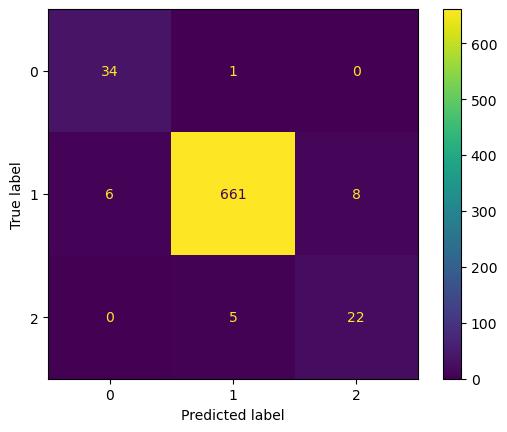

In [27]:
conf_mat = confusion_matrix(y_test, y_pred_test)
        
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                                       display_labels=[0, 1, 2])
disp.plot()

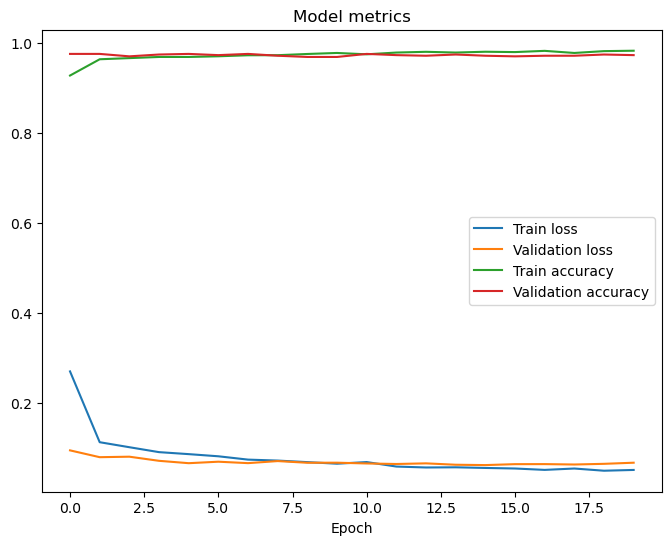

In [28]:
show_history(history)

In [29]:
X_train, X_test, y_train, y_test = dftrain.iloc[:, :-1], dftest.iloc[:, :-1], dftrain.iloc[:, -1], dftest.iloc[:, -1]
y_train, y_test = y_train - 1, y_test - 1
y_train_cat, y_test_cat = to_categorical(y_train, num_classes=3), to_categorical(y_test, num_classes=3)
y_train.shape, y_test.shape, X_train.shape

input_dim = len(dftrain.columns) - 1
input_dim

21

In [30]:
model = get_nn_model(input_dim)

In [31]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
history = model.fit(X_train, y_train_cat, epochs=60, batch_size=16, validation_data=(X_test, y_test_cat))

Epoch 1/60
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8475 - loss: 0.6262 - val_accuracy: 0.9271 - val_loss: 0.2957
Epoch 2/60
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9225 - loss: 0.3134 - val_accuracy: 0.9271 - val_loss: 0.2767
Epoch 3/60
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9235 - loss: 0.2924 - val_accuracy: 0.9271 - val_loss: 0.2609
Epoch 4/60
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9268 - loss: 0.2658 - val_accuracy: 0.9271 - val_loss: 0.2468
Epoch 5/60
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9302 - loss: 0.2472 - val_accuracy: 0.9294 - val_loss: 0.2342
Epoch 6/60
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9284 - loss: 0.2489 - val_accuracy: 0.9326 - val_loss: 0.2259
Epoch 7/60
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9325 - loss: 0.2397 - val_accuracy: 0.9349 - val_loss: 0.2203
Epoch 8/60
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9371 - loss: 0.2108 - val_accuracy: 0.

In [33]:
y_pred_test = model.predict(X_test)
y_pred_test = np.argmax(y_pred_test, axis=1)
evaluate(model, y_test, y_pred_test)

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.9740373395565928
Precision (macro): 0.8732742209868637
Precision (micro): 0.9740373395565928
Precision (weighted): 0.9746351641609605
Recall (macro): 0.861471967738889
Recall (micro): 0.9740373395565928
Recall (weighted): 0.9740373395565928
F1-score (macro): 0.8660745939366276
F1-score (micro): 0.9740373395565928
F1-score (weighted): 0.974217367302668


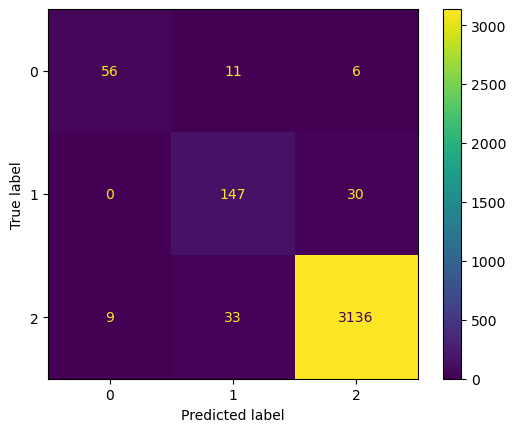

In [34]:
conf_mat = confusion_matrix(y_test, y_pred_test)
        
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                                       display_labels=[0, 1, 2])
disp.plot()

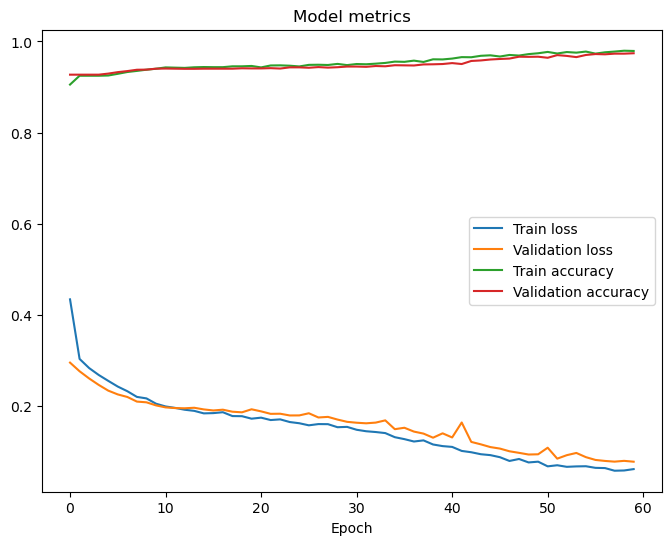

In [35]:

show_history(history)

In [36]:
dfmerged = pd.concat([dftrain, dftest], axis=0)
dfmerged

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,diagnosis
0,0.73,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0.00060,0.0150,0.120,0.082,0.1460,3
1,0.24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00025,0.0300,0.143,0.133,0.1080,3
2,0.47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00190,0.0240,0.102,0.131,0.0780,3
3,0.64,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00090,0.0170,0.077,0.090,0.0850,3
4,0.23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00025,0.0260,0.139,0.090,0.1530,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3423,0.59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.00250,0.0208,0.079,0.099,0.0800,3
3424,0.51,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.10600,0.0060,0.005,0.089,0.0055,1
3425,0.51,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.00076,0.0201,0.090,0.067,0.1340,3
3426,0.35,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00280,0.0201,0.090,0.089,0.1010,3


In [37]:
X = dfmerged.iloc[:, :-1]
y = dfmerged.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
y_train, y_test = y_train - 1, y_test - 1
y_train_cat, y_test_cat = to_categorical(y_train, num_classes=3), to_categorical(y_test, num_classes=3)
input_dim = len(dfmerged.columns) - 1

In [38]:
model = get_nn_model(input_dim)

In [39]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
history = model.fit(X_train, y_train_cat, epochs=40, batch_size=16, validation_data=(X_test, y_test_cat))

Epoch 1/40
405/405 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8628 - loss: 0.5499 - val_accuracy: 0.9264 - val_loss: 0.2870
Epoch 2/40
405/405 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9295 - loss: 0.2849 - val_accuracy: 0.9264 - val_loss: 0.2652
Epoch 3/40
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9339 - loss: 0.2457 - val_accuracy: 0.9292 - val_loss: 0.2365
Epoch 4/40
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9321 - loss: 0.2443 - val_accuracy: 0.9389 - val_loss: 0.2147
Epoch 5/40
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - accuracy: 0.9329 - loss: 0.2293 - val_accuracy: 0.9403 - val_loss: 0.2064
Epoch 6/40
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.9361 - loss: 0.2121 - val_accuracy: 0.9417 - val_loss: 0.2000
Epoch 7/40
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - accuracy: 0.9402 - loss: 0.2053 - val_accuracy: 0.9417 - val_loss: 0.1960
Epoch 8/40
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - accuracy: 0.9389 - loss: 0.2102 - val_accu

In [41]:
y_pred_test = model.predict(X_test)
y_pred_test = np.argmax(y_pred_test, axis=1)
evaluate(model, y_test, y_pred_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.9763888888888889
Precision (macro): 0.8716658171933401
Precision (micro): 0.9763888888888889
Precision (weighted): 0.9807800465794542
Recall (macro): 0.9744857301079191
Recall (micro): 0.9763888888888889
Recall (weighted): 0.9763888888888889
F1-score (macro): 0.9172789479152751
F1-score (micro): 0.9763888888888889
F1-score (weighted): 0.9777024486302216


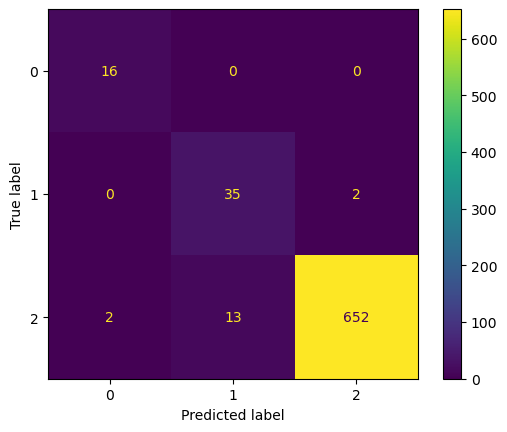

In [42]:
conf_mat = confusion_matrix(y_test, y_pred_test)
        
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                                       display_labels=[0, 1, 2])
disp.plot()

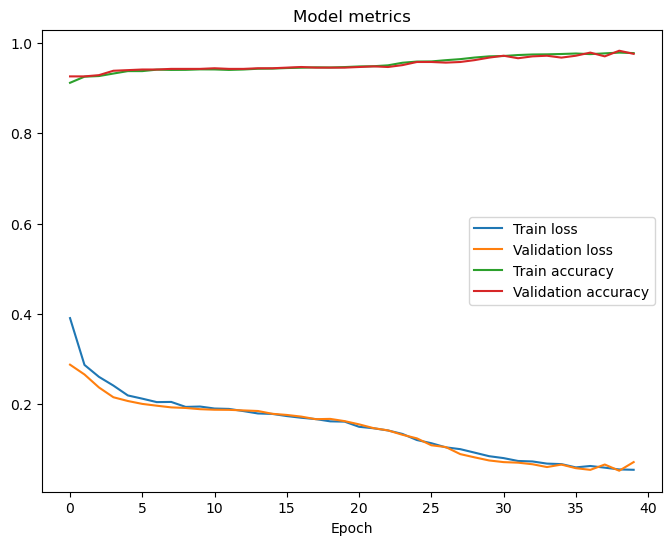

In [43]:

show_history(history)

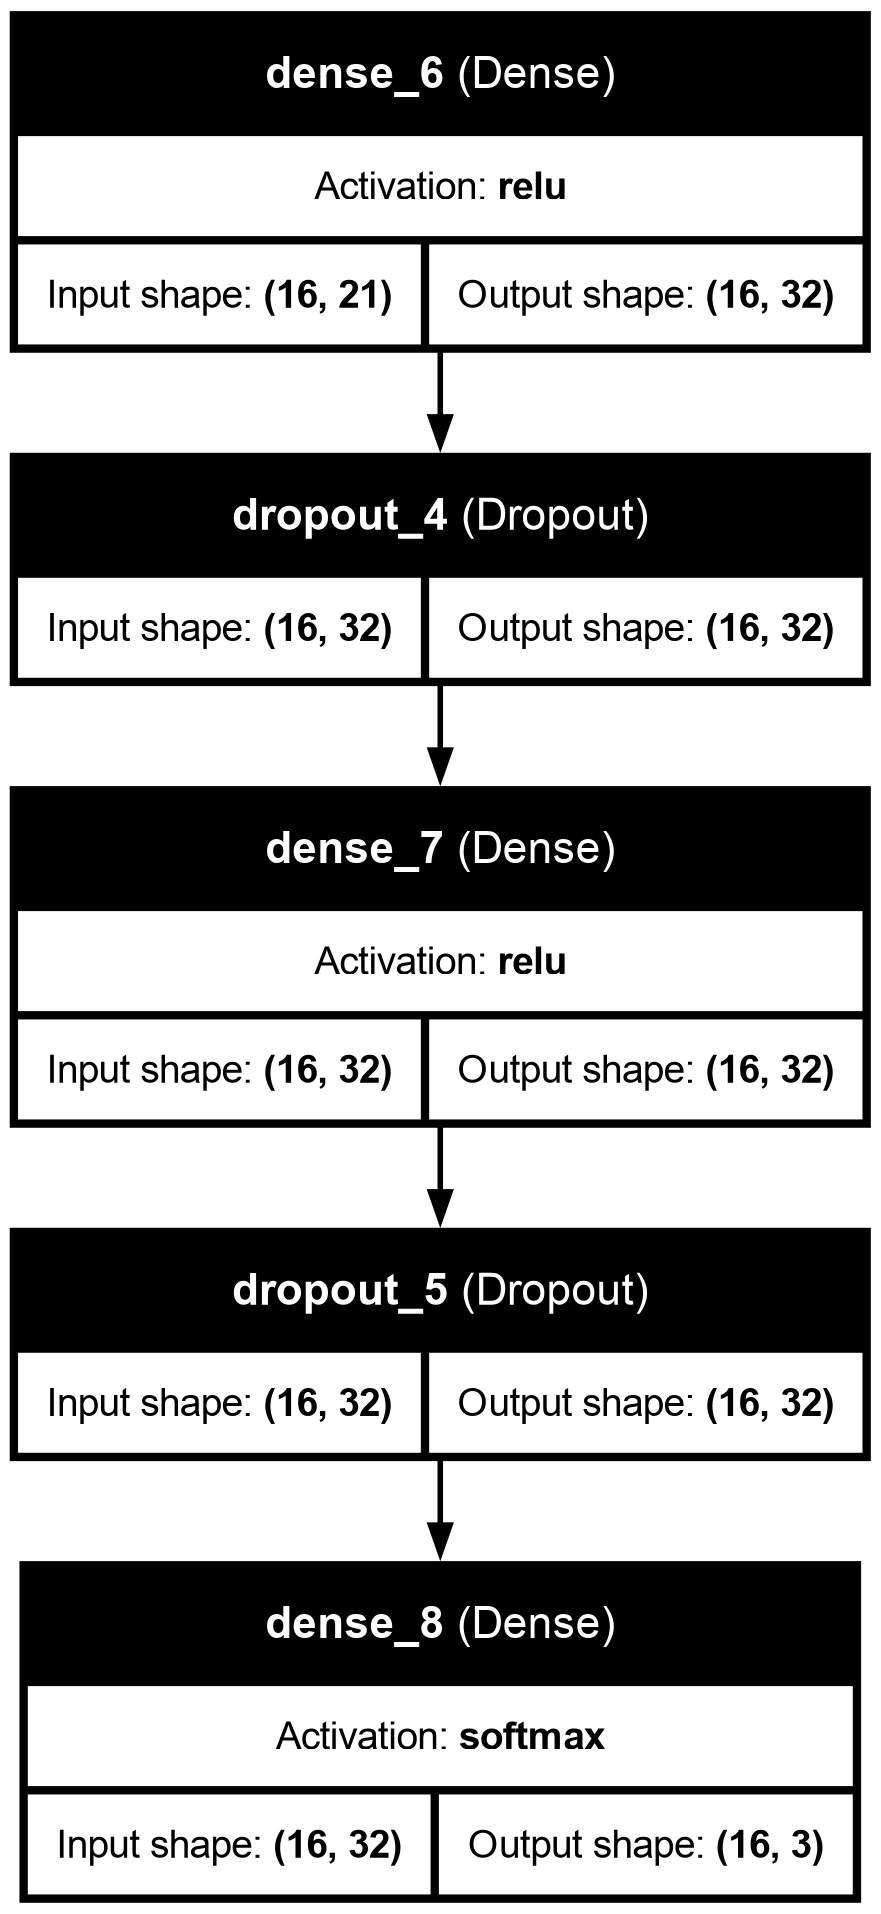

In [44]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, 
           show_layer_names=True,
           show_layer_activations=True)